In [ ]:
#Import the libraries
import pandas as pd
import numpy as np
# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from plot_metric.functions import BinaryClassification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import PowerTransformer

pd.options.display.max_rows = 200

def Find_Optimal_Cutoff(target, predicted):    
    '''Find data-driven cut-off for classification
    
    Cut-off is determined using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    target : array, shape = [n_samples]
        True binary labels.
        
    predicted : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    fpr, tpr, thresholds = roc_curve(target, predicted)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def train_model(data_final, day):
    feature_list_for_training = [ 
           'sex_M',
           'age_18-29',  'age_40-49', 'age_50-59', 'age_60+',
           'substance', 
           'mood', 
           'anxiety', 
           'psychotic', 
           'cognitive', 
           'otherpsych',
           'selfharm', 
           'visit_emr_MH_non_elect', 
           'visit_emr_NonMH',
           'visit_emr_visit', 
           'visit_hosp_visit',
           'visit_hospitalized_MH', 
           'visit_hospitalized_NonMH', 
           'visit_family_gp', 
           'visit_im',
           'visit_neurology', 
           'visit_other', 
           'visit_pharmacy', 
           'visit_psychiatry',
           'EX_CHF', 
           'EX_Arrhy', 
           'EX_VD', 
           'EX_PCD', 
           'EX_PVD', 'EX_HPTN_UC',
           'EX_HPTN_C', 'EX_Para', 'Ex_OthND', 'Ex_COPD', 'Ex_Diab_UC',
           'Ex_Diab_C', 'Ex_Hptothy', 'Ex_RF', 'Ex_LD', 'Ex_PUD_NB', 'Ex_HIV',
           'Ex_Lymp', 'Ex_METS', 'Ex_Tumor', 'Ex_Rheum_A', 'Ex_Coag', 'Ex_Obesity',
           'Ex_WL', 'Ex_Fluid', 'Ex_BLA', 'Ex_DA', 'Ex_Alcohol', 'Ex_Drug',
           'Ex_Psycho', 'Ex_Dep', 'Ex_Stroke', 'Ex_Dyslipid', 'Ex_Sleep', 'Ex_IHD',
           'EX_Fall', 'EX_Urinary', 'EX_Visual', 'EX_Hearing', 'EX_Tobacco',
           'EX_Delirium', 'Ex_MS', 'EX_parkinsons', 
    ]
    # Separate the features for training 
    X = data_final[feature_list_for_training]
    # Separate the labels for training 
    y = data_final['police_interaction']
    
    # Add the constant to the X features
    X = sm.add_constant(X)
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

    # Fit the logistic regression model
    log_reg = sm.Logit(y_train, X_train).fit()

    # Make predictions on the test set
    yhat = log_reg.predict(X_test)
    # Find optimal probability threshold by using the yhat as a continuous measure
    threshold = Find_Optimal_Cutoff(y_test, yhat)

    # Classify the predictions based on the threshold
    prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)
    
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    sensitivity = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    
    number_of_records = len(data_final)
    number_ind_with_first_outcome = data_final[data_final['police_interaction'] == 1].count()[0]

    res = {
        'f1': round(f1, 2),
        'roc_auc': round(roc_auc, 2),
        'sensitivity': round(sensitivity, 2),
        'precision': round(precision, 2),
        'day': day,
        'number_ind_with_first_outcome': number_ind_with_first_outcome,
        'number_of_records': number_of_records
    }

    return res, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, X, y

# Read the data from file
data_final = pd.read_hdf('data/df_sub_police_interaction_preproc.h5', 'df_sub_police_interaction_preproc')

df_results = pd.DataFrame()
df_ = pd.DataFrame()
list_ = [0, 30, 60, 90, 180, 360, 720]

for day in list_:
    data_final_ = data_final[data_final['date_difference'] >= timedelta(day)]
    try:
        res, X_train, X_test, y_train, y_test, prediction, log_reg, feature_list_for_training, X, y = train_model(data_final_, day)
        df_results = pd.concat([df_results, pd.DataFrame(res.values()).T], ignore_index=True)
    except:
        print(day)

df_results.columns = ['f1', 'roc_auc', 'sensitivity', 'precision', "day", "number_ind_with_first_outcome", 'number_of_records']


In [2]:
df_results.sort_values(['roc_auc','sensitivity','precision'], ascending=False)

,f1,roc_auc,sensitivity,precision,day,number_ind_with_first_outcome,number_of_records
4,0.14,0.86,0.87,0.07,180.0,3567.0,237829.0
6,0.11,0.85,0.88,0.06,720.0,2894.0,232869.0
5,0.14,0.84,0.82,0.08,360.0,3401.0,236498.0
2,0.11,0.83,0.87,0.06,60.0,3687.0,238640.0
0,0.11,0.83,0.86,0.06,0.0,3837.0,240218.0
3,0.16,0.83,0.79,0.09,90.0,3647.0,238418.0
1,0.12,0.82,0.84,0.07,30.0,3720.0,238852.0


In [3]:
day=360
data_final_=data_final[data_final['date_difference']>=timedelta(day)]
res,X_train, X_test, y_train, y_test,prediction,log_reg,feature_list_for_training,X,y=train_model(data_final_,day)

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.052841
         Iterations 10


Confusion Matrix : 
 [[20068  3242]
 [   61   279]]
Test accuracy =  0.8603382663847781
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     23310
           1       0.08      0.82      0.14       340

    accuracy                           0.86     23650
   macro avg       0.54      0.84      0.53     23650
weighted avg       0.98      0.86      0.91     23650

F1 Score: 0.1445221445221445
AUC: 0.84%


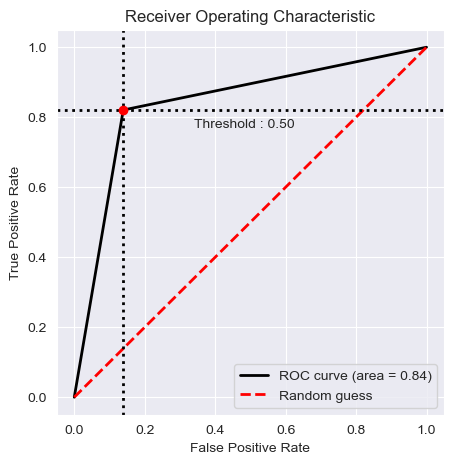

In [4]:
# confusion matrix for the test dataset
cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

print(classification_report(y_test, prediction))

print("F1 Score: {}".format(f1_score(y_test, prediction)))

roc_auc = roc_auc_score(y_test, prediction)
print('AUC: %.2f' % roc_auc + "%")



# Visualisation with plot_metric
bc = BinaryClassification(y_test, prediction, labels = ["Class 1", "Class 2"])

# Figures
plt.figure(figsize = (5,5))
bc.plot_roc_curve()
plt.show()

In [6]:
# Filter the data where 'date_difference' is greater than 360 days
data_final = data_final[data_final['date_difference'] > timedelta(360)]

# Store the logistic regression results in 'result'
result = log_reg

# Calculate and round the exponential of confidence intervals
df_results = np.round(np.exp(result.conf_int()), 2)

# Rename the columns in 'df_results'
df_results.columns = ['2.5%', '97.5%']

# Calculate and store the odds ratios in 'df_results'
df_results['OR'] = pd.DataFrame(np.exp(result.params))
df_results['OR'] = df_results['OR'].map(lambda x: np.round(x, 2))

# Store the p-values in 'df_results' and round them
df_results['P_value'] = np.round(result.pvalues.values, 2)


In [8]:
df_results[['OR','2.5%', '97.5%', 'P_value']].sort_values("OR",ascending=False)

,OR,2.5%,97.5%,P_value
visit_emr_NonMH,6.78,5.39,8.53,0.00
visit_psychiatry,4.39,3.88,4.97,0.00
Ex_Psycho,3.51,3.13,3.95,0.00
visit_pharmacy,2.56,0.70,9.38,0.15
substance,2.33,2.04,2.66,0.00
sex_M,2.04,1.86,2.23,0.00
visit_family_gp,1.79,1.32,2.43,0.00
mood,1.67,1.49,1.88,0.00
visit_hospitalized_NonMH,1.63,1.43,1.86,0.00
Ex_Drug,1.61,1.43,1.81,0.00
